In [ ]:
# This project aims to implement two classic unsupervised learning algorithms, namely Principal 
# Component Analysis (PCA) and K-means. We will implement these to two datasets, Fisher's Iris flower data (1936)
# and the MNIST handwritten digit dataset.

In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the iris data - this data is actually labelled, therefore it will serve as a good performance 
# benchmark for our models. 
def load_data():
    data = np.load('iris.npy')
    return data[:,:-1], data[:,-1]

X_iris, y_iris = load_data()
N, data_dim = X_iris.shape

In [3]:
## PCA
def compute_PCA_parameters(X, M):
    """
    This function computes the first M prinicpal components of a
    dataset X. It returns the mean of the data, the projection matrix,
    and the associated singular values.
    
    OUTPUTS:
    x_bar  : (D,) vector, with the mean of the data
    W      : (D, M) semi-orthogonal matrix of projections
    s      : (D,) vector of singular values
    """

    x_bar = np.mean(X, axis = 0)
    x_new = X - x_bar
    u, s, W = np.linalg.svd(x_new, full_matrices = False)
    W = W[:M, :].T
    W = np.flip(W, axis = 1)
    
    
    return x_bar, W, s

# Compute the first two principal components
N_components = 2
x_bar, W, s = compute_PCA_parameters(X_iris, N_components)

In [4]:
# Self-tests: ensure that all returned matrices have the correct dimensions and that W is orthogonal
assert x_bar.shape == (data_dim,)
assert W.shape == (data_dim, N_components)
assert s.shape == (data_dim,)
assert np.allclose(W.T @ W, np.eye(N_components))

In [5]:
# Methods to transform and un-transform the data
def PCA_transform(X, W, x_bar):
    """ 
    Apply the PCA transformation to data (reducing dimensionality).

    OUTPUT:
    Z     : (N, M) matrix of transformed data
    """
    
    Z = (X - x_bar) @ W
    return Z

def PCA_inverse_transform(Z, W, X_bar):
    """
    Apply the PCA inverse transformation, to reconstruct the data
    from the low-dimensional projection.

    OUTPUT:
    X     : (N, D) matrix; each row is a D-dimensional data point
    """

    X = Z @ W.T + X_bar
    return X

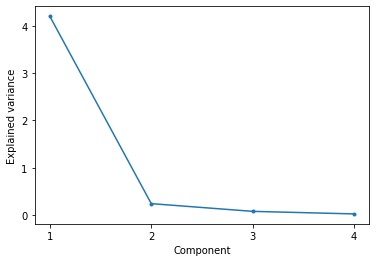

In [6]:
# In the following plot we show the amount of variance captured in each dimension on a per-datapoint scale
plt.plot(np.arange(data_dim)+1, s**2 / N, '.-')
plt.xticks(np.arange(data_dim)+1)
plt.xlabel('Component');
plt.ylabel('Explained variance');

In [7]:
# Another test to check if the implementation is correct: the sum of variance from the remaining dimensions 
# should be equal to the sum of the squared reconstruction error
Z_iris = PCA_transform(X_iris, W, x_bar)
X_hat = PCA_inverse_transform(Z_iris, W, x_bar)

squared_error_tr = ((X_iris - X_hat)**2).sum(-1).mean()
unexplained_variance = (s[N_components:]**2).sum() / N


print("Average squared reconstruction error: %0.5f" % squared_error_tr)
print("Sum of remaining singular values: %0.5f" % unexplained_variance)

Average squared reconstruction error: 0.10136
Sum of remaining singular values: 0.10136


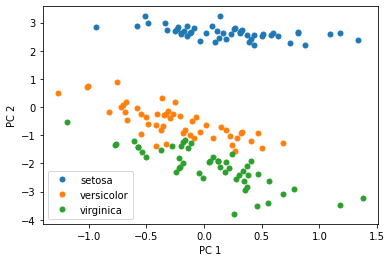

In [8]:
# We can use this to make a 2-D plot of the 4-D dataset (with labels in this case)
plt.figure(figsize=(6,4))
for k in range(3):
    plt.plot(Z_iris[y_iris==k,0], Z_iris[y_iris==k,1], '.', color='C%d'%k, markersize=10)
plt.legend(['setosa', 'versicolor', 'virginica'])
plt.xlabel("PC 1");
plt.ylabel("PC 2");

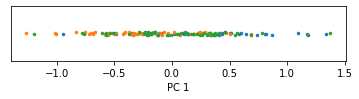

In [9]:
# We can also visualize a 1D reconstruction, since most of the variance appears to be captured by one dimension
plt.figure(figsize=(6,1))
for k in range(3):
    plt.plot(Z_iris[y_iris==k,0], np.random.rand(sum(y_iris==k))*0.1-0.05, '.', color='C%d'%k, markersize=5)
plt.yticks([])
plt.ylim(-1, 1);
plt.xlabel("PC 1");

In [10]:
## K-MEANS
def within_cluster_ss(X, z, mu, K):
    """ Returns the total within-cluster sum of squared distances from centers """
    ss = 0
    for k in range(K):
        ss += ((X[z==k] - mu[k])**2).sum()
    return ss
def update_cluster_means(X, z, K):
    """ 
    Update the cluster means, given the data and a current cluster assignment

    OUTPUT:
    mu    : matrix of cluster centers (means)
    """
    N, D = X.shape

    mu = np.zeros((K, D))
    for i in range(K):
        if (sum(z == i)!=0):
            mu[i, :] = np.mean(X[np.argwhere(z==i), :], axis = 0)
        else:
            mu[i, :] = np.sum(X[np.argwhere(z==i), :], axis = 0)
        
        
    return mu
def update_cluster_assignments(X, mu):
    """ 
    Update cluster assignments, given the data and current cluster means

    OUTPUT:
    z     : vector of integers indicating current cluster assignment
    """

    N, D = X.shape
    K, _ = mu.shape
    
    
    dist = np.linalg.norm(X - mu[:, None], axis = 2)
    z = np.argmin(dist, axis = 0)
    return z


In [12]:
def fit_k_means(X, K):
    """
    Using both `update_cluster_means` and `update_cluster_assignments` to
    implement the K-means algorithm.

    OUTPUTS:
    z     : vector of integers indicating final cluster assignment
    mu    : matrix of final computed cluster centers (means)
    iters : integer, number of iterations required (measured in terms of
            calls to `update_cluster_assignments`).
    """

    N, D = X.shape
    X_mean = np.mean(X,axis=0)
    X_cov = np.cov(X,rowvar=False)
    mu = np.random.multivariate_normal(X_mean,X_cov,(K,))
    
    iters = 0
    tol = 10**-10
    max_it = 20 
    while (iters<max_it):
        iters+=1
        z = update_cluster_assignments(X, mu)
        new_mu = update_cluster_means(X, z, K)
        if np.linalg.norm(new_mu - mu) < tol:
            break
        else:
            mu = new_mu
    
    return z, mu, iters

K = 1: 2 iterations
K = 2: 4 iterations
K = 3: 6 iterations
K = 4: 11 iterations
K = 5: 4 iterations
K = 6: 7 iterations
K = 7: 14 iterations
K = 8: 10 iterations
K = 9: 7 iterations


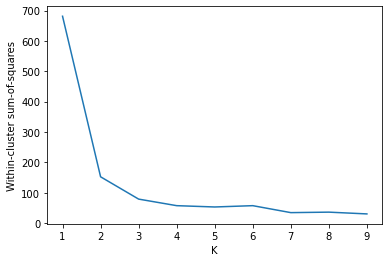

In [13]:
# Plot the K-means loss for a range of K from 1 to 10
WSS = []
res = []
Ks = range(1, 10)
for K in Ks:
    z, mu, iters = fit_k_means(X_iris, K)
    print("K = %d: %d iterations" % (K, iters))
    WSS.append(within_cluster_ss(X_iris, z, mu, K))
    res.append((z, mu))
    
plt.plot(Ks, WSS);
plt.xlabel("K")
plt.ylabel("Within-cluster sum-of-squares");


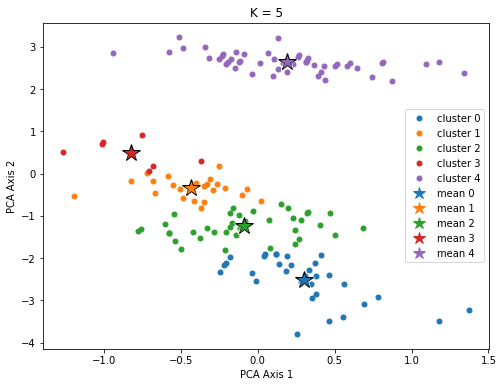

In [14]:
def plot_K_means_pca(X, z, mu, W=None, x_bar=None):
    """ Plot K-means results. Will attempt to use your PCA implementation! 
    
        If your PCA implementation doesn't work, don't worry -- it will fall back
        to just using the first two dimensions of the data instead.
    """
    use_pca = True
    try:
        pca_X = PCA_transform(X, W, x_bar)
        pca_mu = PCA_transform(mu, W, x_bar)
    except:
        pca_X = X
        pca_mu = mu
        use_pca = False
    cluster_ids = np.unique(z)
    for k in cluster_ids:
        plt.plot(pca_X[z==k,0], pca_X[z==k,1], '.', color='C%d'%k, label='cluster %d' % k, markersize=10)
    for k in np.arange(z.max()+1):
        plt.plot(pca_mu[k,0], pca_mu[k,1], '*', color='#fff', markersize=20, label=None)
        plt.plot(pca_mu[k,0], pca_mu[k,1], '*', color='#000', markersize=18, label=None)
        plt.plot(pca_mu[k,0], pca_mu[k,1], '*', color='C%d'%k, markersize=12, label='mean %d' % k)
    if use_pca:
        plt.xlabel("PCA Axis 1")
        plt.ylabel("PCA Axis 2");
    else:
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2");
    plt.legend();

K = 5 #this can be changed 

plt.figure(figsize=(8,6))
plt.title("K = %d" % K)
z, mu = res[K-1]
plot_K_means_pca(X_iris, z, mu, W, x_bar)

In [ ]:
## K-MEANS ON THE MNIST DATA

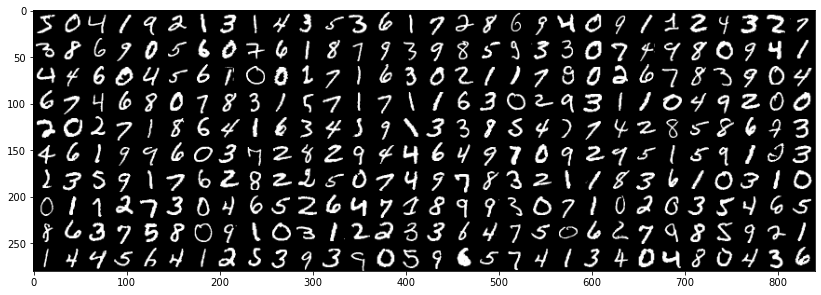

In [15]:
# Load and display the data
MNIST = np.load("mnist.npz")
mnist_images = MNIST['X']

def make_img_grid(images, n_cols=10):
    """ Helper function for arranging images into a grid """
    cols = []
    gap = len(images) % n_cols
    if gap > 0:
        # add padding if needed
        images = np.concatenate((images, np.zeros((n_cols-gap,)+images[0].shape)), 0)
    for n in range(n_cols):
        cols.append(np.concatenate(images[np.arange(n, len(images), step=n_cols)]))
    return np.concatenate(cols, -1)

plt.figure(figsize=(14,7))
plt.imshow(make_img_grid(mnist_images[:300], n_cols=30), cmap='binary_r');

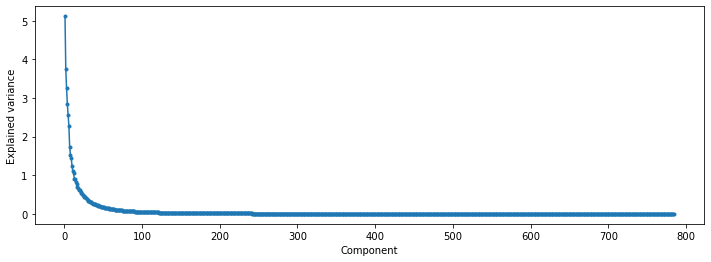

In [19]:
# Use PCA as a pre-processing tool

X_mnist = mnist_images.reshape(-1, 784) # reshape to 2d matrix

mnist_mean, W_mnist, s_mnist = compute_PCA_parameters(X_mnist, 50)

N, data_dim = X_mnist.shape
plt.figure(figsize=(12,4))
plt.plot(np.arange(data_dim)+1, s_mnist**2 / N, '.-')
plt.xlabel('Component');
plt.ylabel('Explained variance');

In [20]:
def k_means_pca_mnist(X_mnist, K):
    """
    Run K-means on PCA-transformed MNIST data.
    
    OUTPUTS:
    z       : vector of integers containing cluster assignments
    iters   : integer, number of iterations 
    """

    N_components = 10 #can change this 

    X_bar, W, S = compute_PCA_parameters(X_mnist, N_components)
    Z = PCA_transform(X_mnist, W, X_bar)
    
    z, mu, iters = fit_k_means(Z, K)
    
    return z, iters

In [21]:
z_mnist, iters = k_means_pca_mnist(X_mnist, K=20)

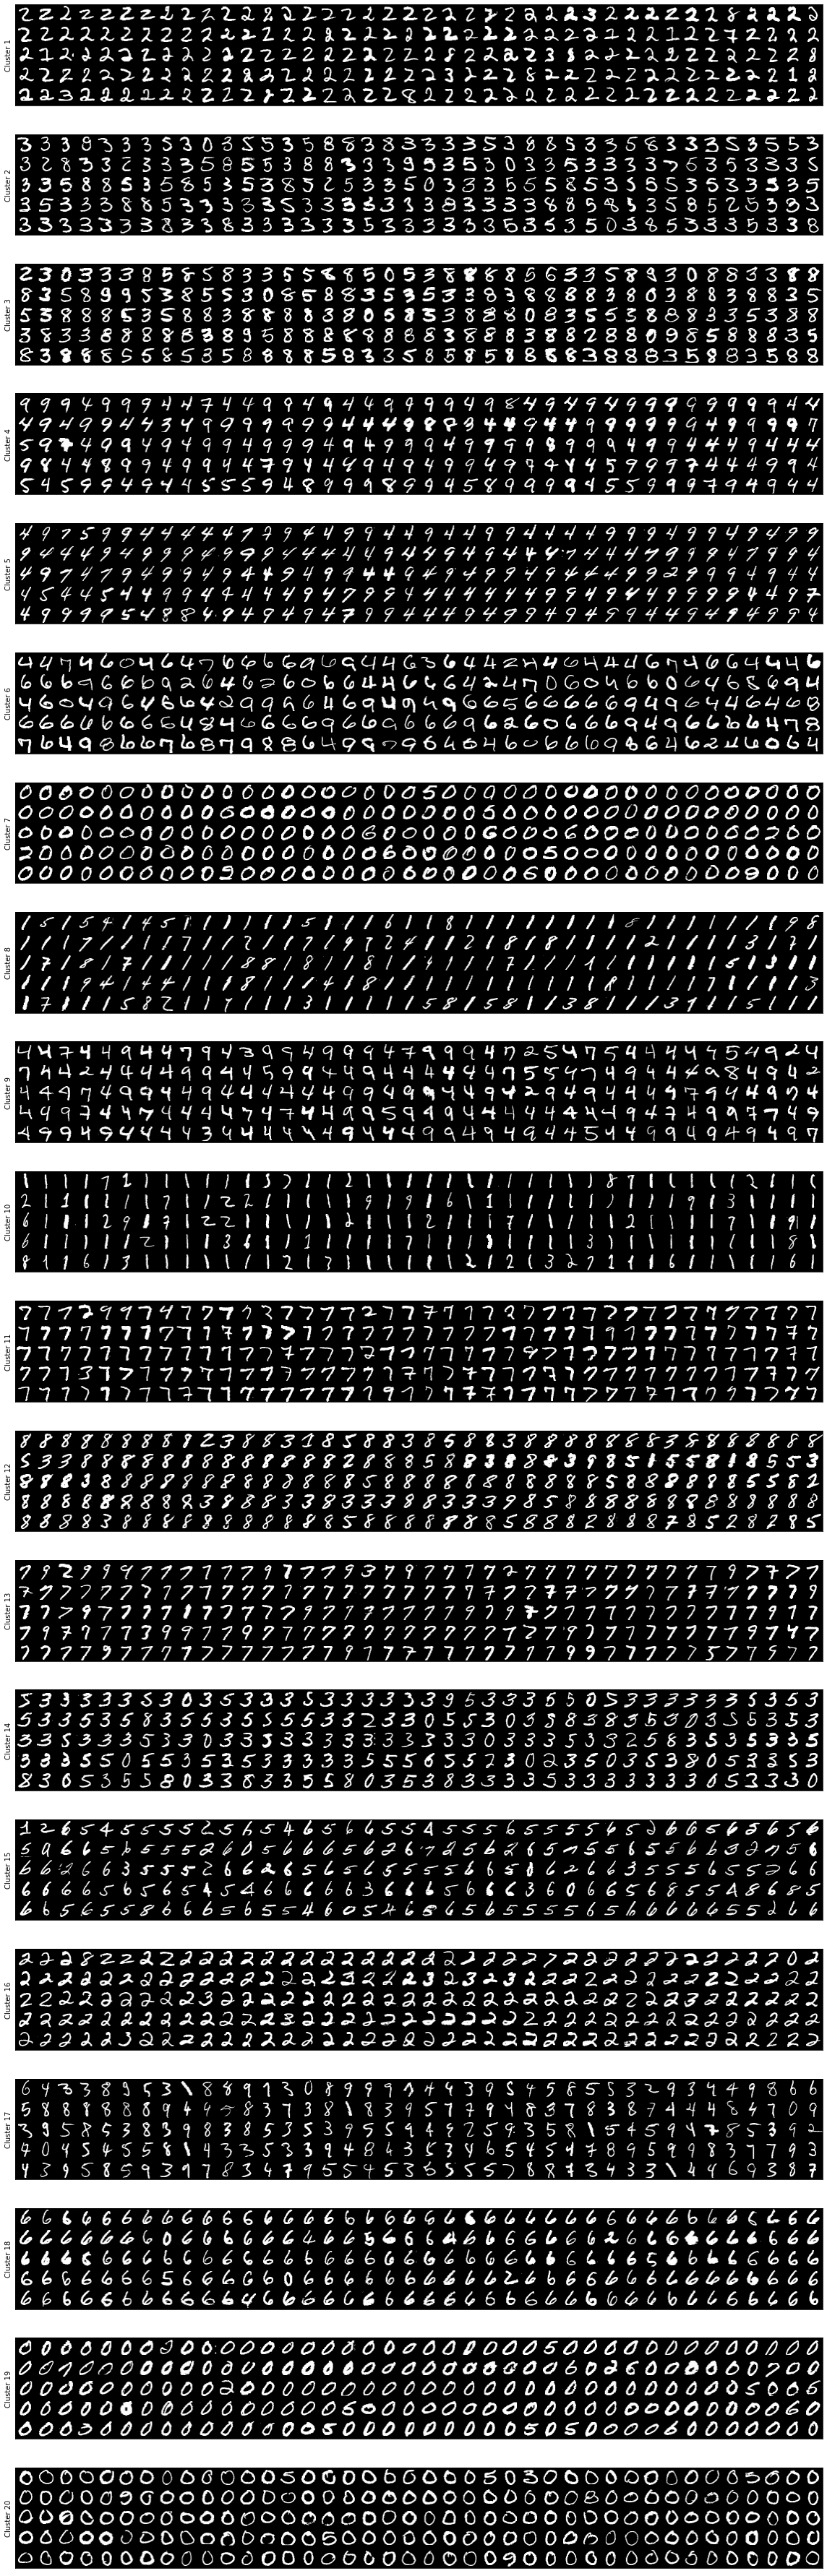

In [22]:
plt.figure(figsize=(16, 50))
for k in range(20):
    plt.subplot(20, 1, k+1)
    plt.imshow(make_img_grid(mnist_images[z_mnist==k][:200], n_cols=40), cmap='binary_r');
    plt.xticks([])
    plt.yticks([])
    plt.ylabel("Cluster %d" % (k+1))
plt.tight_layout();